#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite Volume methods for hyperoblic conservation laws

Hyperbolic conservation laws have the form

$$ u_t + \nabla\cdot f(u) = 0 $$

where the (possibly nonlinear) function $f(u)$ is called the **flux**.  If $u$ has $m$ components, $f(u)$ is an $m\times d$ matrix in $d$ dimensions.  We can express finite volume methods by choosing test functions $v(x)$ that are piecewise constant on each element $e$ and integrating by parts
\begin{split} \int_\Omega v u_t + v \nabla\cdot f(u) = 0 \text{ for all } v \\
 \left( \int_e u \right)_t + \int_{\partial e} f(u) \cdot \hat n = 0 \text{ for all } e .
\end{split}
In finite volume methods, we choose as our unknowns the average values $\bar u$ on each element, leading to the discrete equation
$$ \lvert e \rvert \bar u_t + \int_{\partial e} f(u) \cdot \hat n = 0 \text{ for all } e $$
where $\lvert e \rvert$ is the volume of element $e$.
The most basic methods will compute the interface flux in the second term using the cell average $\bar u$, though higher order methods will perform a reconstruction using neighbors.
Since $\bar u$ is discontinuous at element interfaces, we will need to define a numerical flux using the (possibly reconstructed) value on each side.  First, let's consider some hyperbolic equations.

## Examples in 1D

### Advection
$$ u_t + \nabla\cdot (\underbrace{c u}_{f(u)}) = 0 $$
where $c$ is velocity.  In the absence of boundary conditions, this has the solution
$$ u(t,x) = u(0, x-ct) $$
in terms of the initial condition.  Lines of constant $x-ct$ are called **characteristics**.

### Burger's Equation
$$ u_t + \nabla\cdot (\underbrace{u^2/2}_{f(u)}) = 0 $$
is a model for nonlinear convection.  The wave speed is $f'(u) = u$.

### Traffic

$$ u_t + \nabla\cdot \big(\underbrace{u (1-u)}_{f(u)} \big) = 0 $$
where $u \in [0,1]$ represents density of cars and $1-u$ is their speed.  This is a non-convex flux function.

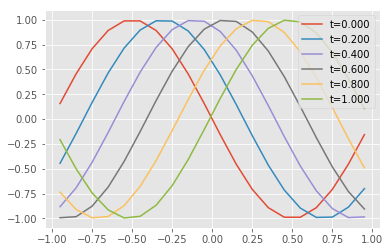

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')
%run fdtools.py

def flux_advection(u):
    return 1*u

def flux_burgers(u):
    return .5*u**2

def flux_traffic(u):
    return u*(1 - u)

def fvsolve0(flux, u0, a=-1, b=1, n=20, tfinal=1):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    idxL = range(-1, n-1)
    def rhs(t, u):
        uL = .5 * (u + u[idxL])
        fluxL = flux(uL)
        div = fluxL.copy()
        div[:-1] -= fluxL[1:]
        div[-1] -= fluxL[0] # Periodic boundary condition
        return div / h
    return x, ode_rkexplicit(rhs, u0(x), h=h, tfinal=tfinal)

def sinpi(x):
    return numpy.sin(-numpy.pi * x)

x, hist = fvsolve0(flux_advection, sinpi)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

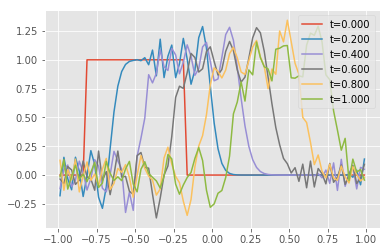

In [2]:
x, hist = fvsolve0(flux_advection,
                   lambda x: (sinpi(x) > .5).astype(float), n=80)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

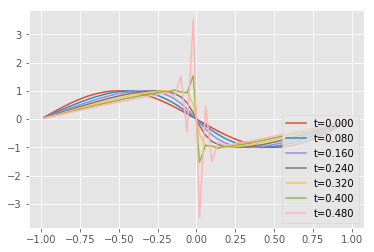

In [3]:
x, hist = fvsolve0(flux_burgers, sinpi, tfinal=.5, n=50)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='lower right');

Evidently our method has problems for discontinuous solutions.

# Shocks, Rarefactions, and Riemann problems

Burger's equation evolved a discontinuity in finite time from a smooth initial condition.  It turns out that all nonlinear hyperbolic equations have this property.  For Burgers, the peak travels to the right, overtaking the troughs.  This is called a **shock** and corresponds to characteristics converging when the gradient of the solution is negative.  When the gradient is positive, the characteristics diverge to produce a **rarefaction**.  The relationship to positive and negative gradients is reversed for a non-convex flux like Traffic.

We need a solution method that can correctly compute fluxes in case of a discontinuous solution.  Finite volume methods represent this in terms of a Riemann problem,
$$ u(0, x) = \begin{cases}
u_L & \text{if} & x < 0 \\
u_R & \text{if} & x > 0
\end{cases}
$$
where $u_L$ and $u_R$ are given.  The solution of a Riemann problem is the solution $u(t, x)$ at positive times.  In our finite volume schemes, it will be sufficient to compute the flux at $x=0$ at an infinitessimal positive time
$$\tilde f(u_L, u_R) = \lim_{t\to 0} f\big(u(t, 0) \big) . $$
We call $\tilde f$ the **numerical flux** and require that it must be consistent when there is no discontinuity,
$$ \tilde f(u, u) = f(u) .$$

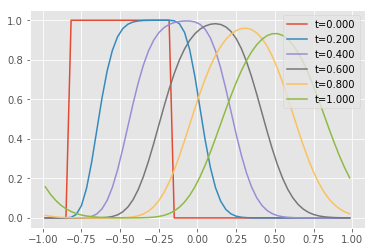

In [4]:
def riemann_advection(uL, uR):
    return 1*uL

def fvsolve1(riemann, u0, a=-1, b=1, n=20, tfinal=1):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    idxL = range(-1, n-1)
    def rhs(t, u):
        fluxL = riemann(u[idxL], u)
        div = fluxL.copy()
        div[:-1] -= fluxL[1:]
        div[-1] -= fluxL[0] # Periodic boundary condition
        return div / h
    return x, ode_rkexplicit(rhs, u0(x), h=h, tfinal=tfinal)

x, hist = fvsolve1(riemann_advection,
                   lambda x: (sinpi(x) > .5).astype(float), n=60)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

## Rankine-Hugoniot condition

For a nonlinear equation, we need to know which direction the shock is moving.  If we move into the reference frame of the shock, the flux on the left must be equal to the flux on the right.  This leads to shock speed $s$ satisfying
$$ s \Delta u = \Delta f \cdot \hat n $$
where $\hat n$ is any direction (e.g., the normal to a face in a multi-dimensional finite volume method).
This condition holds also for hyperbolic systems (where $u$ has multiple components).

For Burger's equation, our Riemann problem produces a shock if $u_L > u_R$, i.e., $\Delta u < 0$.
The shock moves to the right $(s > 0)$ if $\Delta f < 0$, i.e., $f(u_L) > f(u_R)$.

![Toro (2009) Figure 2.13](figures/Toro-Shock-2.13.png)

So if the solution is a shock, the numerical flux is the maximum of $f(u_L)$ and $f(u_R)$.
We still don't know what to do in case of a rarefaction so will just average and see what happens.

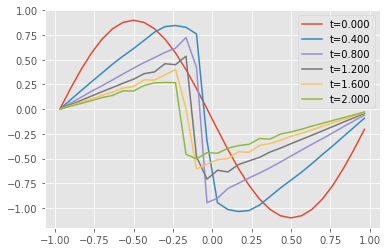

In [5]:
def riemann_burgers_shock(uL, uR):
    return numpy.where(uL > uR,
                       numpy.maximum(flux_burgers(uL), flux_burgers(uR)), # shock
                       flux_burgers(.5*(uL+uR))) # rarefaction

x, hist = fvsolve1(riemann_burgers_shock, lambda x:sinpi(x)-.1, n=30, tfinal=2)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

Much better than before, though we have these odd ripples in the rarefaction.

It turns out that an expansion shock is a **mathematical solution** to the PDE, though such solutions are not physical.

![Toro (2009) Figure 2.14](figures/Toro-ShockRarefaction-2.14.png)

but this violates the **entropy condition**
$$ f'(u_L) > s > f'(u_R) . $$
Shocks are compressive phenomena and physical solutions to the expansive scenario $f'(u_L) < f'(u_R)$ are rarefactions.

![Toro (2009) Figure 2.16](figures/Toro-Rarefaction-2.16.png)

## Entropy functions

Consider a smooth function $\eta(u)$ that is convex $\eta''(u) > 0$ and a smooth solution $u(t,x)$.
Then
$$ u_t + f(u)_x = 0 $$
is equivalent to
$$ u_t + f'(u) u_x = 0 $$
and we can write
$$ \eta'(u) u_t + \eta'(u) f'(u) u_x = 0 . $$
If we find a function $\psi(u)$ such that $\psi'(u) = \eta'(u) f'(u)$, the equation above is equivalent (for smooth solutions) to
$$ \eta(u)_t + \psi(u)_x = 0 $$
which is a conservation law for the entropy $\eta(u)$ with entropy flux $\psi(u)$.

Now consider the parabolic equation
$$ u_t + f(u)_x -\epsilon u_{xx} = 0 $$
for some positive epsilon.  This equation has a smooth solution for any $\epsilon > 0$ and $t > 0$ so we can multpilpy by $\eta'(u)$ as above and apply the chain rule to yield
$$ \eta(u)_t + \psi(u)_x - \epsilon \eta'(u) u_{xx} = 0 . $$
Rearranging the last term produces
$$ \eta(u)_t + \psi(u)_x - \epsilon \Big( \eta'(u) u_x \Big)_x = - \epsilon \eta''(u) u_x^2 . $$
If both terms involving $\epsilon$ were to vanish, we would be left with conservation of entropy.
Now
$$ \int_a^b \Big( \eta'(u) u_x \Big)_x dx = \eta'(u) u_x |_{x=a}^b $$
which is bounded independent of the values $u_x$ may take inside the interval.  Consequently, the left hand side reduces to a conservation law in the limit $\epsilon\to 0$.
The integral of the right hand side, however, does not vanish in the limit since
$$\int_a^b u_x^2$$ is unbounded as $u_x$ grows.
This results in entropy being dissipated across shocks.

#### Mathematical versus physical entropy

Our choice of $\eta(u)$ being a convex function $\eta''(u) > 0$ causes entropy to be dissipated across shocks.  This is a mathematical convention because convex analysis chose this convention.  Physical entropy is produced by such processes, so $-\eta(u)$ would make sense as a physical entropy.

While any convex function will work to show uniqueness for scalar conservation laws, that is not true of hyperbolic systems.  For an actual physical system, entropy is uniquely defined.  For example, the shallow water equations conserve mass and momentum, but energy is only conserved for smooth solutions -- shocks produce heat which is not a conserved variable.

## Looking into the rarefaction fan



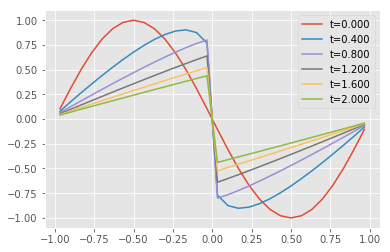

In [6]:
def riemann_burgers(uL, uR):
    return numpy.where(uL > uR,
                       numpy.maximum(flux_burgers(uL), flux_burgers(uR)), # shock
                       numpy.where(uL > 0,
                                   flux_burgers(uL),                # rarefaction moving to the right
                                   flux_burgers(numpy.minimum(uR,   # rarefaction moving to the left
                                                              0)))) # transonic rarefaction

x, hist = fvsolve1(riemann_burgers, sinpi, n=30, tfinal=2)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

### Traffic

Our flux function is
$$ f(u) = u (1 - u) $$
and corresponding wave speed is
$$ f'(u) = 1 - 2 u . $$
The entropy condition for a shock is
$$ f'(u_L) > f'(u_R) $$
which occurs whenever $u_L < u_R$.
According to Rankine-Hugoniot
$$ s \Delta u = \Delta f, $$
the shock moves to the right when $\Delta f = f(u_R) - f(u_L)$ is positive.
A rarefaction occurs when $u_L > u_R$ and moves to the right when $f'(u_L) > 0$ which is the case when $u_L < 0.5$.

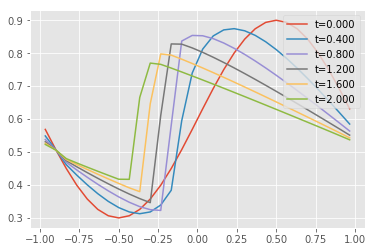

In [7]:
def riemann_traffic(uL, uR):
    return numpy.where(uL < uR,
                       numpy.minimum(flux_traffic(uL), flux_traffic(uR)), # shock
                       numpy.where(uL < .5,
                                   flux_traffic(uL),                # rarefaction moving to the right
                                   flux_traffic(numpy.maximum(uR,   # rarefaction moving to the left
                                                              .5)))) # transonic rarefaction

x, hist = fvsolve1(riemann_traffic, lambda x: .6-.3*sinpi(x), n=30, tfinal=2)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

# Higher order methods

First, a barrier.

### Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE that are monotone can be at most first order accurate.
For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, 0) \ge 0 .$$

### Discontinuities

A numerical method for representing a discontinuous function on a stationary grid can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

## Slope reconstruction

One method for constructing higher order methods is to use the state in neighboring elements to perform a conservative reconstruction of a piecewise polynomial, then compute numerical fluxes by solving Riemann problems at the interfaces.  If $x_i$ is the center of cell $i$ and $g_i$ is the reconstructed gradient inside cell $i$, our reconstructed solution is
$$ \tilde u_i(x) = u_i + g_i \cdot (x - x_i) . $$
We would like this reconstruction to be monotone in the sense that
$$ \Big(\tilde u_i(x) - \tilde u_j(x) \Big) \Big( u_i - u_j \Big) \ge 0 $$
for any $x$ on the interface between element $i$ and element $j$.

#### Question
Is the symmetric slope
$$ \hat g_i = \frac{u_{i+1} - u_{i-1}}{2 \Delta x} $$
monotone?

We will determine gradients by "limiting" the above slope using a nonlinear function that reduces to 1 when the solution is smooth.  There are many ways to express limiters and our discussion here roughly follows [Berger, Aftosmis, and Murman (2005)](https://www.nas.nasa.gov/assets/pdf/techreports/2005/nas-05-007.pdf).

![Berger et al, figure 3b, Cell averages](figures/Berger2005-3b-CellAverages.png)

We will express a slope limiter in terms of the ratio
$$ r_i = \frac{u_ - u_{i-1}}{u_{i+1} - u_{i-1}} $$
and use as a gradient,
$$ g_i = \phi(r_i) \frac{u_{i+1} - u_{i-1}}{2 \Delta x} . $$
Our functions $\phi$ will be zero unless $0 < r < 1$ and $\phi(1/2) = 1$.
![Berger et al, figure 3a, Symmetric form of slope limiters](figures/Berger2005-3a-SymSlope.png)
All of these limiters are second order accurate and TVD; those that fall below minmod are not second order accurate and those that are above Barth-Jesperson are not second order accurate, not TVD, or produce artifacts.

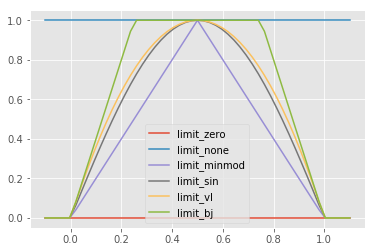

In [8]:
limiters = []
def limappend(lim):
    limiters.append(lim)
    return lim

@limappend
def limit_zero(r):
    return 0*r

@limappend
def limit_none(r):
    return 0*r+1

@limappend
def limit_minmod(r):
    return numpy.maximum(numpy.minimum(2*r, 2*(1-r)), 0)

@limappend
def limit_sin(r):
    return numpy.where(numpy.all((0 < r, r < 1), axis=0),
                      numpy.sin(numpy.pi*r),
                      0)

@limappend
def limit_vl(r):
    return numpy.maximum(4*r*(1-r), 0)

@limappend
def limit_bj(r):
    return numpy.clip(numpy.minimum(4*r, 4*(1-r)), 0, 1)

r = numpy.linspace(-.1, 1.1, 51)
for lim in limiters:
    pyplot.plot(r, lim(r), label=lim.__name__)
pyplot.legend(loc='lower center');

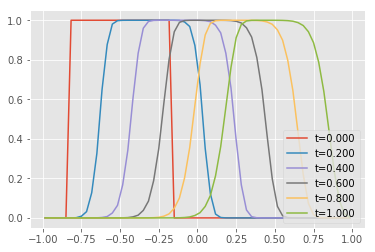

In [9]:
def fvsolve2(riemann, u0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, u):
        jump = u[idxR] - u[idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(u - u[idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(u[idxL] + g[idxL] * h/2, u - g * h/2)
        return (fluxL - fluxL[idxR]) / h
    return x, ode_rkexplicit(rhs, u0(x), h=h, tfinal=tfinal)

x, hist = fvsolve2(riemann_advection,
                   lambda x: (sinpi(x) > .5).astype(float), n=60, limit=limit_sin)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='lower right');

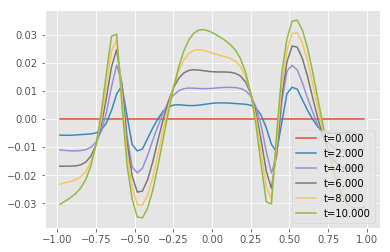

In [10]:
x, hist = fvsolve2(riemann_advection, sinpi, n=60, tfinal=10, limit=limit_bj)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u - sinpi(x-t), label='t={:.3f}'.format(t))
pyplot.legend(loc='lower right');

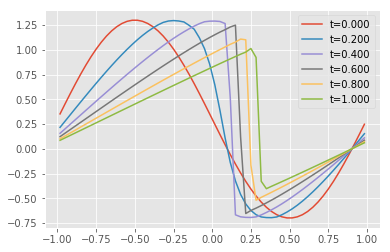

In [11]:
x, hist = fvsolve2(riemann_burgers,
                   lambda x: sinpi(x)+.3, n=60, limit=limit_bj)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

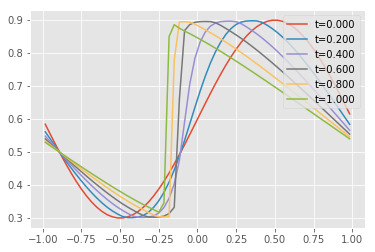

In [12]:
x, hist = fvsolve2(riemann_traffic, lambda x: .6-.3*sinpi(x),
                   n=60, limit=limit_sin)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

# Systems of equations

The equations for isentropic gas dynamics are
$$ U_t + f(U)_x = 0 $$
with
\begin{align} U &= \begin{bmatrix} \rho \\ \rho u \end{bmatrix} & f(U) &= \begin{bmatrix} \rho u \\ \rho u^2 + p \end{bmatrix} \end{align}
where

| Variable | meaning |
|----------|--------|
| $\rho$ | density |
| $u$    | velocity |
| $\rho u$ | momentum |
| $p$      | pressure |

and the equation of state is
$$ p(\rho) = C \rho^\gamma, \quad \gamma = 1.4 . $$
Note that since the conserved variables are density and momentum, we compute
$$ \rho u^2 = \frac{(\rho u)^2}{\rho} .$$
A simpler equation of state,
$$ p(\rho) = c^2 \rho $$
where $c$ is the acoustic wave speed results in isothermal gas dynamics.

For perturbations of a constant state, systems of equations produce multiple waves with speeds equal to the eigenvalues of the flux Jacobian,
$$ f'(U) = \begin{bmatrix} 0 & 1 \\ -u^2 + c^2 & 2 u \end{bmatrix}. $$
We can compute the eigenvalues and eigenvectors,
$$ f'(U) = W \Lambda W^{-1} $$
as
\begin{align} 
W &= \begin{bmatrix} 1 & 1 \\ u-c & u+c \end{bmatrix} &
\Lambda &= \begin{bmatrix} u-c &  \\ & u+c \end{bmatrix} .
\end{align}
This makes intuitive sense, we have an acoustic wave traveling in the same direction as the fluid and in the opposite direction.

## The Riemann problem for systems
Given states $U_L$ and $U_R$, we will see two waves with some state $U^*$ in between.  There could be two shocks, two rarefactions, or one of each.
The type of wave will determine the condition that must be satisfied to connect $U_L$ to $U_*$ and $U^*$ to $U_R$.

### Shocks
If there is a shock between $U_L$ and $U_*$, the Rankine-Hugoniot condition
$$ s \Delta U = \Delta f $$
will be satisfied along with the entropy condition
$$ \lambda_i(U_L) \ge s \ge \lambda_i(U_*) $$
where $\lambda_i(U)$ is the corresponding eigenvalue of the flux Jacobian $f'(U)$.
The inequality in the entropy condition is strict if the wave is genuinely nonlinear.
For isothermal gas dynamics, the Rankine-Hugoniot condition is
\begin{align}
 (\rho_* - \rho_L) s &= \rho_* u_* - \rho_L u_L \\
 (\rho_* u_* - \rho_L u_L) s &= \Big(\rho_* u_*^2 + c^2 \rho_* \Big) - \Big( \rho_L u_L^2 + c^2 \rho_L \Big)
\end{align}
Solving the first equation for $s$ and substituting into the second, we compute
\begin{split} \frac{(\rho_* u_* - \rho_L u_L)^2}{\rho_* - \rho_L} &= \rho_* u_*^2 - \rho_L u_L^2 + c^2 (\rho_* - \rho_L) \\
 \rho_*^2 u_*^2 - 2 \rho_* \rho_L u_* u_L + \rho_L^2 u_L^2 &= \rho_* (\rho_* - \rho_L) u_*^2 - \rho_L (\rho_* - \rho_L) u_L^2 + c^2 (\rho_* - \rho_L)^2 \\
 \rho_* \rho_L \Big( u_*^2 - 2  u_* u_L + u_L^2 \Big) &= c^2 (\rho_* - \rho_L)^2 \\
 (u_* - u_L)^2 &= c^2 \frac{(\rho_* - \rho_L)^2}{\rho_* \rho_L} \\
 u_* - u_L &= \pm c \frac{\rho_* - \rho_L}{\sqrt{\rho_* \rho_L}}
\end{split}
and will need to use the entropy condition to learn which sign to take.
The entropy condition requires that
$$ \lambda(U_L) = u_L - c \ge s \ge u_* - c = \lambda(U_*) . $$
Meanwhile, the first Rankine-Hugoniot condition and $\rho > 0$ provides
$$  \rho_L c \le \rho_L (u_L - s) = \rho_* (u_* - s) \le \rho_* c $$
which is to say that $\rho_* \ge \rho_L$ and consequently we take the negative sign,
$$ u_* - u_L = - \frac{\rho_* - \rho_L}{\sqrt{\rho_* \rho_L}} .$$
The same process for the right wave $\lambda(U) = u + c$ yields a shock when $\rho_* \ge \rho_R$, in which case the velocity jump is
$$ u_R - u_* = - c \frac{\rho_* - \rho_R}{\sqrt{\rho_* \rho_R}} . $$

### Rarefactions
A rarefaction occurs when
$$ \lambda_i(U_L) < \lambda_i(U_R) $$
and the generalized Riemann invariant
$$ \frac{d U^1}{W_i^1} = \frac{d U^2}{W_i^2} = \dotsb $$
will hold.  (Derivation of this condition is beyond the scope of this class.)
For isothermal gas dynamics, this condition is
$$ \frac{d \rho}{1} = \frac{d (\rho u)}{u - c} $$
across the wave $\lambda = u-c$.
We can rearrange to
$$ (u-c) d \rho = \rho d u + u d \rho $$
or
$$ d u + \frac{c}{\rho} d \rho = 0 . $$
Integration yields
$$ u + \int \frac{c}{\rho} d \rho = u + c \log \rho = \text{constant} . $$
So if we have a rarefaction between $U_L$ and $U_*$ then
$$ u_L + c \log \rho_L = u_* + c \log \rho_* . $$
Similarly, for the wave $\lambda = u + c$, a rarefaction between $U_*$ and $U_R$ results in
$$ u_* - c \log \rho_* = u_R - c \log \rho_R . $$
If the rarefaction is sonic, we have $u_0 - c = 0$ for a left rarefaction (or $u_0 + c =0$ for the right) and can compute $\rho_0$ from
$$ u_* -c \log \rho_* = u_0 - c \log \rho_0 .$$

If we know $\rho_*$, we know whether each wave is a shock or rarefaction and thus can compute $u_*$ using the Rankine-Hugoniot or the generalized Riemann invariant respectively.
In general we will need to use a Newton method to solve for the state in the star region.

In [13]:
def flux_isogas(U, c):
    rho = U[0]
    u = U[1] / rho
    return numpy.array([U[1], U[1]*u + c**2*rho])

def riemann_isogas(UL, UR, c, maxit=20):
    rhoL = UL[0]
    rhoR = UR[0]
    uL = UL[1] / rhoL
    uR = UR[1] / rhoR
    rho = .5*(rhoL + rhoR)  # Initial guess to Newton solve
    for i in range(maxit):
        ujumpL = numpy.where(rho > rhoL,
                            (rhoL - rho) / numpy.sqrt(rho*rhoL),    # shock
                            c * (numpy.log(rhoL) - numpy.log(rho))) # rarefaction
        ujumpR = numpy.where(rho > rhoR,
                            (rhoR - rho) / numpy.sqrt(rho*rhoR),    # shock
                            c * (numpy.log(rhoR) - numpy.log(rho))) # rarefaction
        residual = ujumpL + ujumpR - (uR - uL)
        # print('{: 2d} {:10.2e} {:5f} {:5f}'.format(i, numpy.linalg.norm(residual), min(rho), max(rho)))
        if numpy.linalg.norm(residual) < 1e-10:
            u = uL + ujumpL
            break
        elif i+1 == maxit:
            raise RuntimeError('Newton solver failed to converge')
        dujumpL = numpy.where(rho > rhoL,
                             -(1 + .5*(rhoL - rho)/rho)/numpy.sqrt(rho*rhoL), # shock
                              -c / rho)                                       # rarefaction
        dujumpR = numpy.where(rho > rhoR,
                             -(1 + .5*(rhoR - rho)/rho)/numpy.sqrt(rho*rhoR), # shock
                              -c / rho)                                       # rarefaction
        delta_rho = -residual / (dujumpL + dujumpR)
        while min(rho + delta_rho) <= 0:  # line search to prevent negative density
            delta_rho *= .5
        rho += delta_rho
    U0 = numpy.zeros_like(UL)
    for i in range(len(rho)):
        if uL[i] - c < 0 < u[i] - c or u[i] + c < 0 < uR[i] + c:
            # Inside left (right) sonic rarefaction
            U0[0,i] = numpy.exp(-(u[i] - numpy.sign(u[i])*c - c*numpy.log(rho[i]))/c)
            U0[1,i] = U0[0,i] * numpy.sign(u[i])*c
        elif ((rhoL[i] >= rho[i] and 0 <= uL[i] - c) or
              (rhoL[i] < rho[i] and 0 < (rho[i]*u[i] - UL[1,i]))):
            # Left rarefaction or shock is supersonic
            U0[:,i] = UL[:,i]
        elif ((rhoR[i] >= rho[i] and uR[i] + c <= 0) or
              (rhoR[i] < rho[i] and UR[1][i] - rho[i]*u[i]) > 0):
            # Right rarefaction or shock is supersonic
            U0[:,i] = UR[:,i]
        else:
            # Sample star state
            U0[0,i] = rho[i]
            U0[1,i] = rho[i]*u[i]
    return flux_isogas(U0, c)

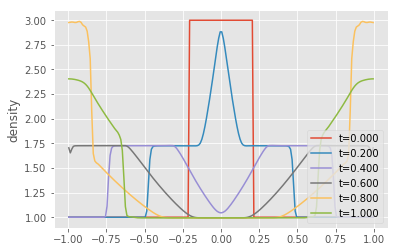

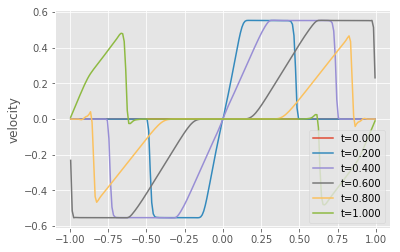

In [14]:
def fvsolve2system(riemann, U0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod, args = ()):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=h/5, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

def initial_isogas(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2)>.5),
                        0*x])

x, hist = fvsolve2system(riemann_isogas, initial_isogas, n=200, limit=limit_vl, args=(1,))
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('density')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

In [15]:
numpy.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## Approximate Riemann solvers

Exact Riemann solvers are quite complicated to implement and fragile in the sense that small changes to the physics, such as in the equation of state $p(\rho)$, can require changing many conditionals.  Also, the need to solve for $\rho^*$ using a Newton method and then evaluate each case of the wave structure can be very expensive.  For some equations, an exact Riemann solver has never been implemented.

One popular approximate Riemann solver, HLL (Harten, Lax, and van Leer), assumes two shocks with speeds $s_L$ and $s_R$.  These speeds will be estimated and must be at least as fast as the fastest left- and right-traveling waves.  If the wave speeds $s_L$ and $s_R$ are given, we have the Rankine-Hugoniot conditions across both shocks,
\begin{align}
  s_L (U_* - U_L) &= f(U_*) - f(U_L) \\
  s_R (U_R - U_*) &= f(U_R) - f(U_*) .
\end{align}
Adding these together gives
$$ s_R U_R - (s_R - s_L) U_* - s_L U_L = f(U_R) - f(U_L) $$
which can be solved for $U_*$ as
$$ U_* = \frac{f(U_L) - f(U_R) - s_L U_L + s_R U_R}{s_R - s_L} . $$
We can save an extra evaluation of the flux by using the Rankine-Hugoniot conditions
$$ f(U_*) = \frac{s_R f(U_L) - s_L f(U_R) + s_L s_R (U_R - U_L)}{s_R - s_L} . $$

For isothermal gas dynamics, we can estimate wave speeds as
$$ s_L = \min( u_L - c, u_R - c ), \quad s_R = \max(u_L + c, u_R + c) . $$

The Rusanov method is the special case $s_L = - s_R$, in which case the wave structure is always subsonic and the flux is simply
$$f(U_*) = \frac 1 2 \Big( f(U_L) + f(U_R) \Big) - \frac s 2 \Big( U_R - U_L \Big) . $$

#### Observations
* The term involving $U_R-U_L$ represents diffusion and will cause entropy to decay (physical entropy is produced).
* If our Riemann problem produces shocks and we have correctly calculated the wave speeds, the HLL solver is exact and produces the minimum diffusion necessary for conservation.
* If the wave speed estimates are slower than reality, the method will be unstable due to CFL.
* If the wave speed estimates are faster than reality, the method will be more diffusive than an exact Riemann solver.

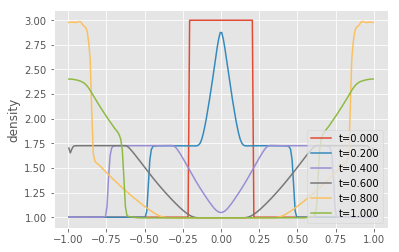

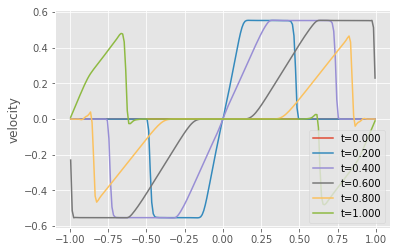

In [16]:
def riemann_isogas_hll(UL, UR, c):
    rhoL = UL[0]
    rhoR = UR[0]
    uL = UL[1] / rhoL
    uR = UR[1] / rhoR
    sL = numpy.minimum(uL - c, uR - c)
    sR = numpy.maximum(uL + c, uR + c)
    fL = flux_isogas(UL, c)
    fR = flux_isogas(UR, c)
    return numpy.where(sL > 0, fL,
                       numpy.where(sR < 0, fR,
                                   (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))

def initial_isogas(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2) > .5),
                        0*x])

x, hist = fvsolve2system(riemann_isogas_hll, initial_isogas, n=200, limit=limit_vl, args=(1,))
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('density')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');

# Homework 4 (due 2017-11-17)
1. Implement a solver for the shallow water equations,
$$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$
where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential.
The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.
* Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.
* The total energy in the system is kinetic plus potential energy
$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$
Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.
* Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL?  Does it depend on your choice of limiter in slope reconstruction?

# Multiple dimensions; unstructured grids

While finite difference methods require the ability to evaluate derivatives in an accurate and stable way, finite volume methods need only integrals of fluxes.  This is a natural fit for unstructured grids and complicated geometry.

In [17]:
import pygmsh

geom = pygmsh.built_in.Geometry()
geom.add_circle((0,0,0), 1, 1.5)
points, elements, _, _, _ = pygmsh.generate_mesh(geom)

Upgrade to   meshio 1.9.1    available! (installed: 1.8.17)

To upgrade meshio with pip, type

   pip install -U meshio

To upgrade _all_ pip-installed packages, use

   pipdate/pipdate3

To disable these checks, set SecondsBetweenChecks in /home/jed/.config/pipdate/config.ini to -1.

Info    : Running 'gmsh -3 -bin /tmp/tmp_0j63lj4.geo -o /tmp/tmpuz_2kw1s.msh -optimize_lloyd 10' [Gmsh 3.0.6, 1 node, max. 1 thread]
Info    : Started on Wed Nov  8 12:05:45 2017
Info    : Reading '/tmp/tmp_0j63lj4.geo'...
Info    : Done reading '/tmp/tmp_0j63lj4.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Done meshing 1D (0.000861 s)
Info    : Meshing 2D...
Info    : Meshing surface 5 (Plane, Delaunay)
Info    : Meshing surface 5 (Plane, MeshAdapt)
Info    : Done meshing 2D (0.007816 s)
Info    : Meshing 3D...
Info    : Done meshing 3D (6.7e-0

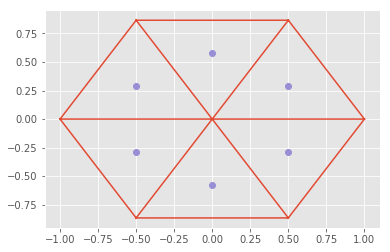

In [18]:
points = points[:,:2]
tri = elements['triangle']
centroids = (points[tri[:,0]] + points[tri[:,1]] + points[tri[:,2]]) / 3
pyplot.triplot(points[:,0], points[:,1], triangles=tri)
pyplot.plot(centroids[:,0], centroids[:,1], 'o');

In [19]:
volumes = numpy.abs(numpy.cross(points[tri[:,1]] - points[tri[:,0]],
                                points[tri[:,2]] - points[tri[:,1]])) / 2
edges = tri[:,[0,1,1,2,2,0]].reshape((-1,2))
edges.sort(axis=1)
print(edges.reshape((-1,6)), 'edges by cell')
ind = numpy.lexsort((edges[:,1], edges[:,0]))
edge2vertex, starts, perm, counts = numpy.unique(edges[ind], axis=0, return_index=True,
                                                 return_inverse=True, return_counts=True)
print(edge2vertex, 'edge2vertex')
cell2edge = numpy.empty(len(edges), dtype=int)
cell2edge[ind] = perm
cell2edge = cell2edge.reshape((-1, 3))
print(cell2edge, 'cell2edge')

edge2cell = ind[starts[:,None]] * [1,1] // 3
edge2cell[counts > 1,1] = ind[starts[counts > 1]+1] // 3
print(edge2cell, 'edge2cell')

[[0 5 5 6 0 6]
 [0 3 3 6 0 6]
 [1 4 4 6 1 6]
 [1 3 3 6 1 6]
 [2 5 5 6 2 6]
 [2 4 4 6 2 6]] edges by cell
[[0 3]
 [0 5]
 [0 6]
 [1 3]
 [1 4]
 [1 6]
 [2 4]
 [2 5]
 [2 6]
 [3 6]
 [4 6]
 [5 6]] edge2vertex
[[ 1 11  2]
 [ 0  9  2]
 [ 4 10  5]
 [ 3  9  5]
 [ 7 11  8]
 [ 6 10  8]] cell2edge
[[1 1]
 [0 0]
 [0 1]
 [3 3]
 [2 2]
 [2 3]
 [5 5]
 [4 4]
 [4 5]
 [1 3]
 [2 5]
 [0 4]] edge2cell


In [20]:
edgecenters = .5*(points[edge2vertex[:,0]] + points[edge2vertex[:,1]])
edgenormals = (points[edge2vertex[:,0]] - points[edge2vertex[:,1]])[:,[1,0]]
edgeweights = numpy.linalg.norm(edgenormals, axis=1)
edgenormals /= edgeweights[:,None]

# Orient the normals
dots = numpy.sum((centroids[edge2cell[:,1]] - centroids[edge2cell[:,0]]) * edgenormals, axis=1)
edgenormals[dots < 0] *= -1

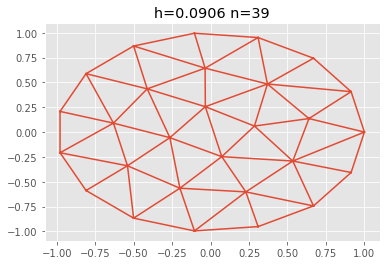

In [21]:
class Mesh:
    def __init__(self, points, tri):
        self.points = points
        self.tri = tri
        volumes = numpy.abs(numpy.cross(points[tri[:,1]] - points[tri[:,0]],
                                points[tri[:,2]] - points[tri[:,1]])) / 2
        centroids = (points[tri[:,0]] + points[tri[:,1]] + points[tri[:,2]]) / 3
        edges = tri[:,[0,1,1,2,2,0]].reshape((-1,2))
        edges.sort(axis=1)
        ind = numpy.lexsort((edges[:,1], edges[:,0]))
        edge2vertex, starts, perm, counts = numpy.unique(edges[ind], axis=0,
                        return_index=True, return_inverse=True, return_counts=True)
        cell2edge = numpy.empty(len(edges), dtype=int)
        cell2edge[ind] = perm
        cell2edge = cell2edge.reshape((-1, 3))
        edge2cell = ind[starts[:,None]] * [1,1] // 3
        edge2cell[counts > 1,1] = ind[starts[counts > 1]+1] // 3
        edgecenters = .5*(points[edge2vertex[:,0]] + points[edge2vertex[:,1]])
        edgenormals = (points[edge2vertex[:,0]] - points[edge2vertex[:,1]]) @ [[0,1],[-1,0]]
        edgeweights = numpy.linalg.norm(edgenormals, axis=1)
        edgenormals /= edgeweights[:,None]
        dots = numpy.sum((centroids[edge2cell[:,1]] - centroids[edge2cell[:,0]]) * edgenormals, axis=1)
        edgenormals[dots < 0] *= -1
        self.centroids = centroids
        self.cell2edge = cell2edge
        self.edge2cell = edge2cell
        self.edgecenters = edgecenters
        self.edgenormals = edgenormals
        self.cell2edge_weight = numpy.where(edge2cell[cell2edge,0] == numpy.arange(len(volumes))[:,None],
                                            +1, -1) * edgeweights[cell2edge] / volumes[:,None]
        self.h = numpy.min(numpy.linalg.norm(numpy.kron([1,1], self.edgecenters).reshape((-1,2))
                                   - self.centroids[self.edge2cell.flatten()], axis=1))

geom = pygmsh.built_in.Geometry()
geom.add_circle((0,0,0), 1, .5)
points, elements, _, _, _ = pygmsh.generate_mesh(geom, verbose=False)
mesh = Mesh(points[:,:2], elements['triangle'])
pyplot.triplot(mesh.points[:,0], mesh.points[:,1], triangles=mesh.tri)
pyplot.title('h={:.4f} n={:d}'.format(mesh.h, len(mesh.centroids)));

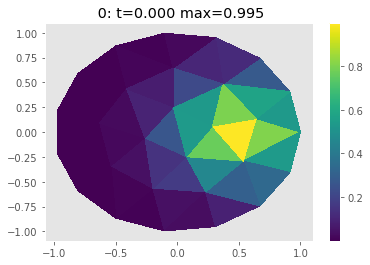

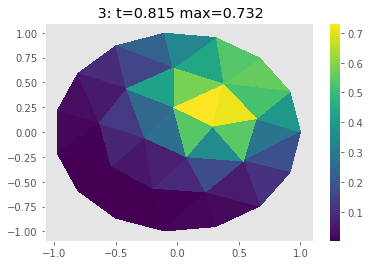

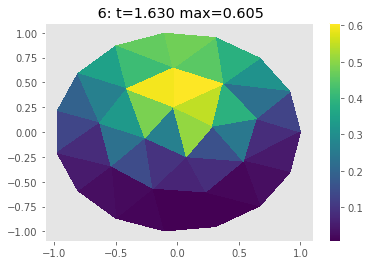

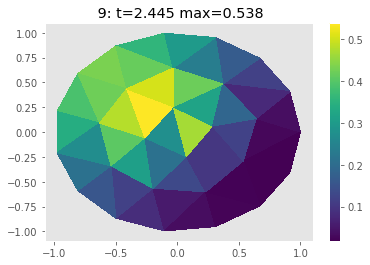

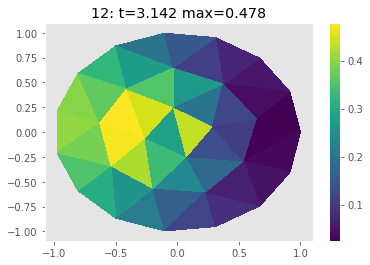

In [22]:
def riemann2d_advect(uL, uR, x, normal):
    c = x @ [[0, 1], [-1, 0]]
    cn = (c*normal).sum(axis=1)
    return numpy.where(cn > 0, uL, uR) * cn
        
def fvsolve1tri(mesh, riemann2d, U0, tfinal=1):
    U0x = U0(mesh.centroids)
    Ushape = U0x.shape
    def rhs(t, U):
        U = U.reshape(Ushape)
        UL = U[mesh.edge2cell[:,0]]
        UR = U[mesh.edge2cell[:,1]]
        flux = riemann2d(UL, UR, mesh.edgecenters, mesh.edgenormals)
        return -(flux[mesh.cell2edge] * mesh.cell2edge_weight).sum(axis=1)
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=3*mesh.h, tfinal=tfinal)
    return [(t, U.reshape(Ushape)) for t, U in hist]

def initial2d(x):
    return numpy.exp(-4*numpy.linalg.norm(x - [.5,0], axis=1)**2)

hist = fvsolve1tri(mesh, riemann2d_advect, initial2d, tfinal=numpy.pi)
for step in numpy.linspace(0, len(hist)-1, 5, dtype=int):
    t, U = hist[step]
    pyplot.figure()
    pyplot.tripcolor(mesh.points[:,0], mesh.points[:,1], triangles=mesh.tri, facecolors=U)
    pyplot.colorbar()
    pyplot.title('{:2d}: t={:.3f} max={:.3f}'.format(step, t, numpy.max(U)))

### Observations

* Triangles are often considered to be inefficient.  The dual mesh is a popular alternatve.
* This is a first-order method and thus very diffusive.
* We have punted on boundary conditions by reflecting the interior state across each exterior edge.
* Sampling the divergence-free velocity field onto the edge centers does not produce a velocity field that is exactly divergence-free on each element.  It is possible to make the *discrete* field velocity free by solving a Laplacian.